In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import  warnings
warnings.simplefilter('ignore')

In [268]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree

# Data Loading

In [3]:
data = pd.read_csv('employee_retention_data.csv')

In [4]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [6]:
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

In [8]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


The maximum of seniority (99) seems to be unreasonable. Some data cleaning is required.

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='seniority', ylabel='Density'>

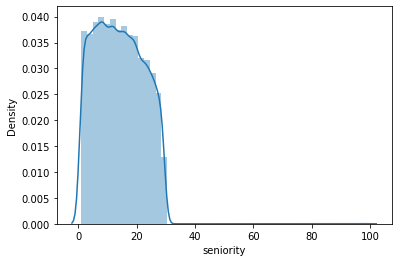

In [12]:
fig,axs = plt.subplots(1,1)
sns.distplot(data['seniority'])

In [17]:
data = data[data['seniority']<=45]

## Task(a):
Create a table with 3 columns: day, employee_headcount, company_id.

In [24]:
data['quit_date'].isnull().sum()

11192

In [25]:
len(data)

24700

In [26]:
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
...,...,...,...,...,...,...,...
24695,63273.0,1,data_science,5,172000.0,2012-05-01,2015-06-26
24696,94644.0,6,marketing,7,88000.0,2012-01-26,2013-02-01
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT


In [42]:
date_range = pd.date_range('2011-01-24','2015-12-13')
unique_company = sorted(data['company_id'].unique())


In [45]:
days, company_id, cnt = [],[],[]
for day in date_range:
    for company in unique_company:
        days.append(day)
        company_id.append(company)

        join_cnt = len(data[(data['join_date']<=day)&(data['company_id']==company)])
        quit_cnt = len(data[(data['quit_date']<=day)&(data['company_id']==company)])

        cnt.append(join_cnt-quit_cnt)

In [47]:
hc = pd.DataFrame()
hc['Day'] = days
hc['Company_ID'] = company_id
hc['headcount'] = cnt

In [48]:
hc

,Day,Company_ID,headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5
...,...,...,...
21415,2015-12-13,8,468
21416,2015-12-13,9,432
21417,2015-12-13,10,385
21418,2015-12-13,11,4


## Task(b): Employee Churn Analysis

## EDA

In [75]:
data = data.sort_values(by='company_id')

In [76]:
retention = data[data['quit_date'].isna()]
quit = data[~data['quit_date'].isna()]
len(retention), len(quit)

(11192, 13508)

In [213]:
colors = ['lightblue','steelblue','lightsteelblue']
plt.rcParams['xtick.labelsize'] = 10

In [187]:
def quit_ratio(df1_ren,df2_quit,col):
    tmp1 = df1_ren.groupby(col)['employee_id'].count().reset_index().rename(columns={'employee_id':'rentention_cnt'})
    tmp2 = df2_quit.groupby(col)['employee_id'].count().reset_index().rename(columns={'employee_id':'quit_cnt'})
    tmp = tmp1.merge(tmp2,on=col)
    tmp = tmp.set_index(col)

    tmp_copy = tmp.copy()
    tmp_copy['sum'] = tmp['rentention_cnt'] + tmp['quit_cnt']
    tmp_copy = tmp_copy.iloc[:,:-1].div(tmp_copy.iloc[:,-1],axis=0)

    fig,axs = plt.subplots(1,2,figsize=(20,6))
    
    tmp.plot.bar(color=colors,ax=axs[0],stacked=True)
    tmp_copy.plot.bar(color=colors,ax=axs[1],stacked=True)
    
    plt.suptitle('The rentention and quit number',fontsize=20)

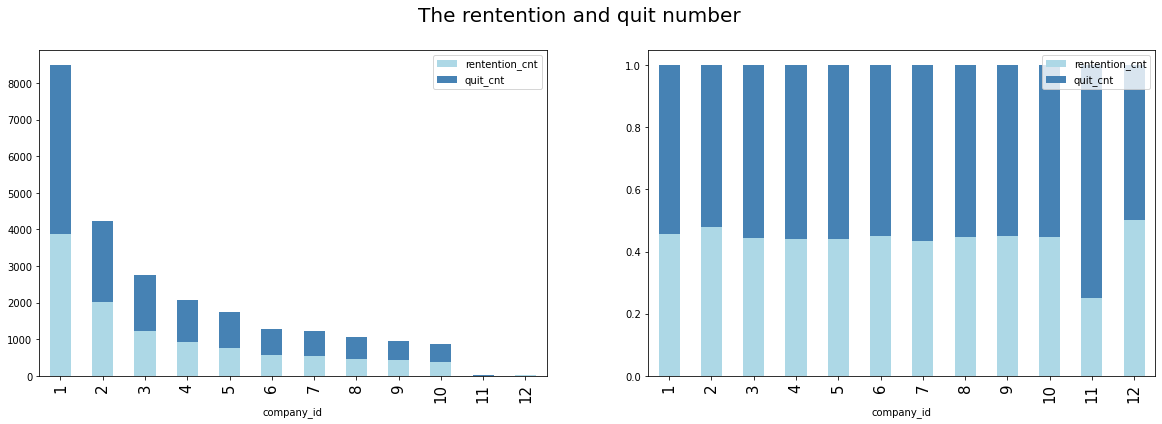

In [188]:
quit_ratio(retention,quit,'company_id')

It seems that quit_ratio in most of the companies is near to 50% (except for Company 10).

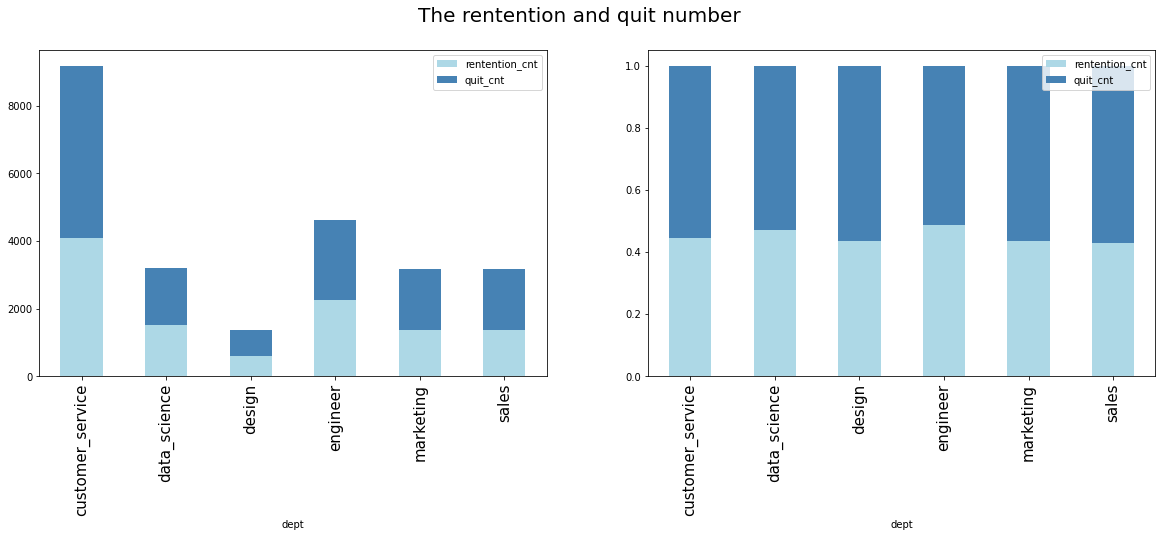

In [189]:
quit_ratio(retention,quit,'dept')

It seems that quit_ratio in most of the depts is near to 50%.

In [210]:
quit['interval'] = list(map(lambda x: x.days,quit['quit_date'] - quit['join_date'] ))

Text(0.5, 1.0, 'Distribution of working days')

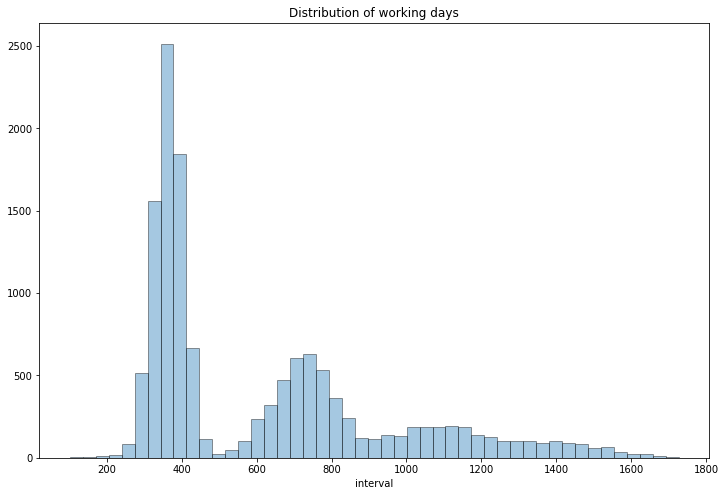

In [221]:
fig,ax = plt.subplots(figsize = (12,8))
sns.distplot(quit['interval'],kde=False, hist_kws={'edgecolor':'black'})
plt.title('Distribution of working days')

The peak appears at the end of year.

<AxesSubplot:xlabel='dayofweek'>

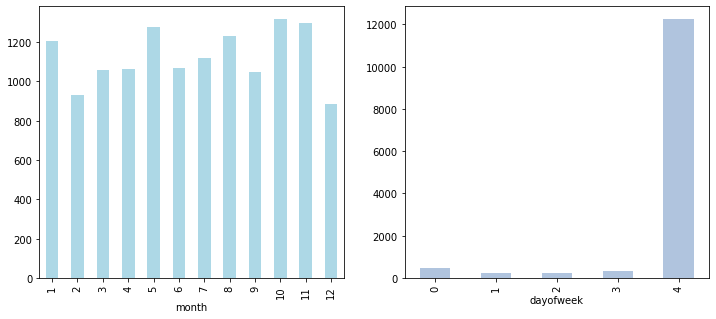

In [232]:
quit['month'] = quit['quit_date'].apply(lambda x: x.month)
quit['dayofweek'] = quit['quit_date'].apply(lambda x: x.dayofweek)

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
quit.groupby('month')['employee_id'].count().plot.bar(ax=ax1,color=colors[0])
ax2 = fig.add_subplot(1,2,2)
quit.groupby('dayofweek')['employee_id'].count().plot.bar(ax=ax2,color=colors[2])


Most of the employees tend to quit on Fridays.

In [233]:
quit

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,interval,month,dayofweek
9217,935122.0,1,marketing,24,181000.0,2013-07-02,2014-06-06,339,6,4
9219,397018.0,1,sales,16,216000.0,2012-12-17,2013-12-19,367,12,3
19831,358740.0,1,engineer,11,184000.0,2013-01-28,2015-03-20,781,3,4
19830,408349.0,1,customer_service,29,126000.0,2012-12-31,2014-12-05,704,12,4
19824,536585.0,1,customer_service,12,78000.0,2011-10-31,2012-12-07,403,12,4
...,...,...,...,...,...,...,...,...,...,...
10255,808516.0,12,customer_service,3,18000.0,2012-11-12,2013-10-25,347,10,4
2750,582569.0,12,customer_service,3,18000.0,2011-05-16,2012-05-04,354,5,4
16599,165867.0,12,customer_service,10,42000.0,2012-11-26,2014-09-19,662,9,4
7229,348474.0,12,data_science,12,110000.0,2013-07-29,2015-05-08,648,5,4


[Text(0, 0, '(16638.0, 89400.0]'),
 Text(1, 0, '(89400.0, 161800.0]'),
 Text(2, 0, '(161800.0, 234200.0]'),
 Text(3, 0, '(234200.0, 306600.0]'),
 Text(4, 0, '(306600.0, 379000.0]')]

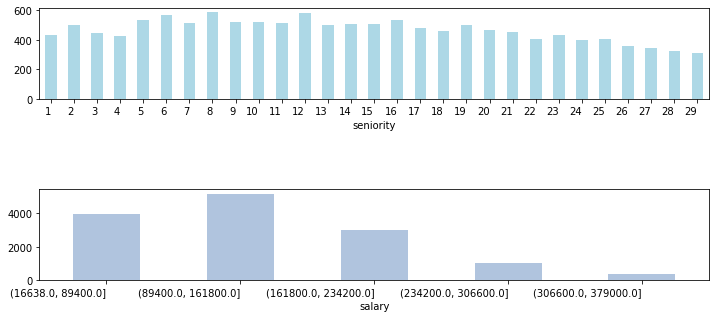

In [244]:
quit_copy = quit.copy()

#quit_copy['seniority'] = pd.cut(quit_copy['seniority'],bins=5)
quit_copy['salary'] = pd.cut(quit_copy['salary'],bins=5)

fig = plt.figure(figsize=(12,5))
plt.subplots_adjust(hspace=1)
ax1 = fig.add_subplot(2,1,1)
quit_copy.groupby('seniority')['employee_id'].count().plot.bar(ax=ax1,color=colors[0])
ax2 = fig.add_subplot(2,1,2)
quit_copy.groupby('salary')['employee_id'].count().plot.bar(ax=ax2,color=colors[2])

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='right')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='right')

It seems that the employees with the second lowest salay range are most likely to quit.

## Build a Decision Tree model to visualize the feature importance.

In [251]:
data['quit_date'] = 

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
8083,470548.0,1,customer_service,8,63000.0,2015-03-16,NaT
19840,225235.0,1,sales,3,46000.0,2015-06-29,NaT
9210,590185.0,1,engineer,4,70000.0,2015-03-04,NaT
19838,658860.0,1,customer_service,7,80000.0,2015-03-02,NaT
9217,935122.0,1,marketing,24,181000.0,2013-07-02,2014-06-06
...,...,...,...,...,...,...,...
23747,142534.0,12,data_science,1,48000.0,2015-03-23,NaT
7229,348474.0,12,data_science,12,110000.0,2013-07-29,2015-05-08
1535,252076.0,12,marketing,18,117000.0,2013-12-17,NaT
10094,449311.0,12,engineer,28,184000.0,2013-04-15,NaT


In [259]:
data['quit_date'].isnull()

8083      True
19840     True
9210      True
19838     True
9217     False
         ...  
23747     True
7229     False
1535      True
10094     True
1680     False
Name: quit_date, Length: 24700, dtype: bool

In [262]:
def if_quit(x):
    if pd.isna(x):
        return 0
    else:
        return 1
data['quit'] = data['quit_date'].apply(if_quit)

In [263]:
#Label_encoder
data_tree = data[['company_id','dept','seniority','salary','quit']]
le = LabelEncoder()
data_tree['dept'] = le.fit_transform(data_tree['dept'])

In [264]:
le.classes_

array(['customer_service', 'data_science', 'design', 'engineer',
       'marketing', 'sales'], dtype=object)

In [267]:
X, y = data_tree.iloc[:,:-1],data_tree.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [269]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [272]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.904223820170403, 0.5020242914979757)

In [284]:
from sklearn.metrics import classification_report
y_hat = clf.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.46      0.50      0.48      3707
           1       0.55      0.50      0.53      4444

    accuracy                           0.50      8151
   macro avg       0.50      0.50      0.50      8151
weighted avg       0.51      0.50      0.50      8151



In [283]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=X_train.columns.tolist())
print(r)

|--- salary <= 246500.00
|   |--- salary <= 51500.00
|   |   |--- dept <= 2.50
|   |   |   |--- salary <= 20500.00
|   |   |   |   |--- salary <= 18500.00
|   |   |   |   |   |--- company_id <= 6.50
|   |   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- company_id >  6.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- salary >  18500.00
|   |   |   |   |   |--- company_id <= 11.00
|   |   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |   |--- company_id <= 5.00
|   |   |   |   |   |   |   |   |--- seniority <= 3.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- seniority >  3.50
|   |   |   |   |   |   |   |   |   |--- salary <= 19500.00
|   |   |   |   |   |   |   |   |   |   |--- cla

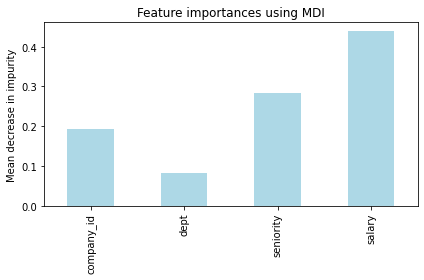

In [288]:
features_names = X_train.columns[:]
importances = clf.feature_importances_
indice = np.argsort(importances)
forest_importances = pd.Series(importances, index=features_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax,color=colors[0])
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Salary is the most important factor and Seniority is the second most important one.

In [289]:
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
8083,470548.0,1,customer_service,8,63000.0,2015-03-16,NaT,0
19840,225235.0,1,sales,3,46000.0,2015-06-29,NaT,0
9210,590185.0,1,engineer,4,70000.0,2015-03-04,NaT,0
19838,658860.0,1,customer_service,7,80000.0,2015-03-02,NaT,0
9217,935122.0,1,marketing,24,181000.0,2013-07-02,2014-06-06,1
...,...,...,...,...,...,...,...,...
23747,142534.0,12,data_science,1,48000.0,2015-03-23,NaT,0
7229,348474.0,12,data_science,12,110000.0,2013-07-29,2015-05-08,1
1535,252076.0,12,marketing,18,117000.0,2013-12-17,NaT,0
10094,449311.0,12,engineer,28,184000.0,2013-04-15,NaT,0


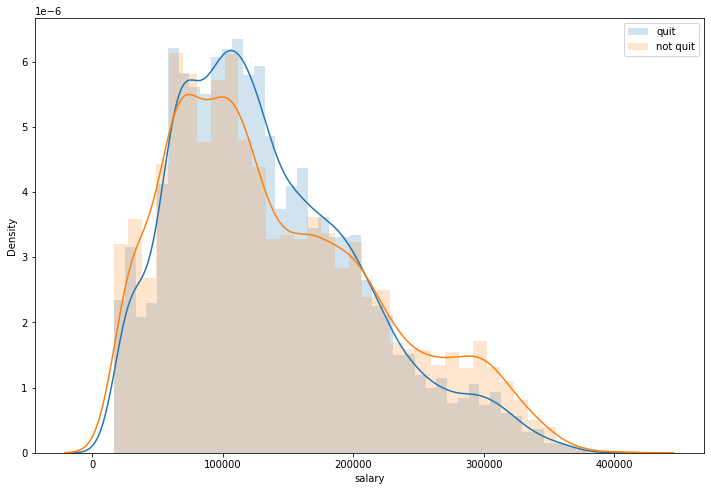

In [302]:
fig,axs = plt.subplots(figsize=(12,8))
sns.distplot(quit['salary'],label='quit',hist_kws={'alpha':0.2})
sns.distplot(retention['salary'],label='not quit',hist_kws={'alpha':0.2})
plt.legend()

Those employees whose salary are within the lowest range or within the highest range are less likely to quit.

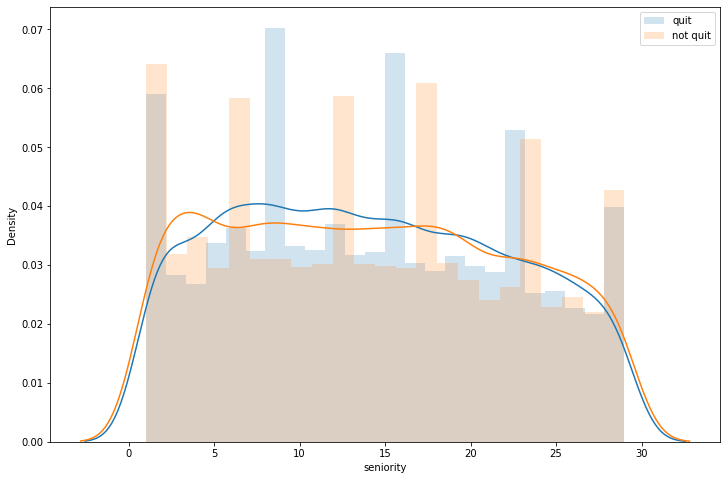

In [303]:
fig,axs = plt.subplots(figsize=(12,8))
sns.distplot(quit['seniority'],label='quit',hist_kws={'alpha':0.2})
sns.distplot(retention['seniority'],label='not quit',hist_kws={'alpha':0.2})
plt.legend()

To find the characteristics of the people who quit early.
Early_quitters: who quit within the first 13 months.

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
8083,470548.0,1,customer_service,8,63000.0,2015-03-16,NaT,0
19840,225235.0,1,sales,3,46000.0,2015-06-29,NaT,0
9210,590185.0,1,engineer,4,70000.0,2015-03-04,NaT,0
19838,658860.0,1,customer_service,7,80000.0,2015-03-02,NaT,0
9217,935122.0,1,marketing,24,181000.0,2013-07-02,2014-06-06,1
...,...,...,...,...,...,...,...,...
23747,142534.0,12,data_science,1,48000.0,2015-03-23,NaT,0
7229,348474.0,12,data_science,12,110000.0,2013-07-29,2015-05-08,1
1535,252076.0,12,marketing,18,117000.0,2013-12-17,NaT,0
10094,449311.0,12,engineer,28,184000.0,2013-04-15,NaT,0


In [315]:
from datetime import timedelta
data_earlyquit = data.copy()
data_earlyquit = data_earlyquit[data_earlyquit["join_date"] + timedelta(days=365+31) <= '2015-12-13']
data_earlyquit = data_earlyquit.iloc[:,:-1]
data_earlyquit['diff'] = (data_earlyquit['quit_date'] - data_earlyquit['join_date'])

In [317]:
def if_earlyquit(x):
    if x.days <= 365+31:
        return 1
    else:
        return 0

data_earlyquit['if_earlyquit'] = data_earlyquit['diff'].apply(if_earlyquit)

In [325]:
dtree_data = data_earlyquit[['company_id','dept','seniority','salary','if_earlyquit']]

In [326]:
dtree_data['dept'] = le.transform(dtree_data['dept'])

In [328]:
X,y = dtree_data.iloc[:,:-1],dtree_data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [329]:
dtree.score(X_train,y_train),dtree.score(X_test,y_test)

(0.9309997676759855, 0.5933029397893413)

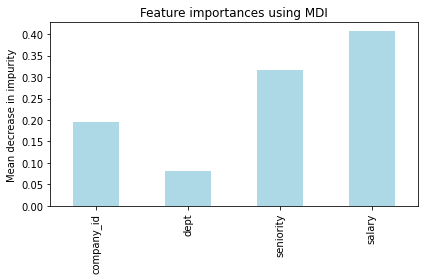

In [330]:
features_names = X_train.columns[:]
importances = dtree.feature_importances_
indice = np.argsort(importances)
forest_importances = pd.Series(importances, index=features_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax,color=colors[0])
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Salary is still the most important reason for early quitters.